# Life Expectancy to GDP

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

### Data exploration

First lets load all the data into a pandas dataframe and take a look at the first few rows.
We have four columns; Country, Year, Life expectancy at birth (years) and GDP.

In [2]:
gdp = pd.read_csv('all_data.csv')

In [3]:
gdp.head()

,Country,Year,Life expectancy at birth (years),GDP
0,Chile,2000,77.3,7.786093e+10
1,Chile,2001,77.3,7.097992e+10
2,Chile,2002,77.8,6.973681e+10
3,Chile,2003,77.9,7.564346e+10
4,Chile,2004,78.0,9.921039e+10


In [4]:
gdp.describe()

,Year,Life expectancy at birth (years),GDP
count,96.000000,96.000000,9.600000e+01
mean,2007.500000,72.789583,3.880499e+12
std,4.633971,10.672882,5.197561e+12
min,2000.000000,44.300000,4.415703e+09
25%,2003.750000,74.475000,1.733018e+11
50%,2007.500000,76.750000,1.280220e+12
75%,2011.250000,78.900000,4.067510e+12
max,2015.000000,81.000000,1.810000e+13


For brevity's sake, let's change the 'Life expectancy at birth (years)' column name to 'Life expectancy'

In [5]:
columns = gdp.columns.tolist()
columns[2] = 'Life expectancy'
gdp.columns = columns

Lets see which countries are represented in the data.
Six countries are listed below.

In [6]:
countries = gdp.Country.unique()
for country in countries:
    print(country)

Chile
China
Germany
Mexico
United States of America
Zimbabwe


And change 'United States of America to 'USA'

usa_str = 'United States of America'
size = gdp[gdp.Country==usa_str].shape[0]
gdp.loc[gdp.Country==usa_str, 'Country'] = ['USA'] * size
gdp[gdp.Country=='USA'].head()

And let's take a look at which years are represented.

In [7]:
gdp.Year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015])

## The big picture

The obvious question to ask of this data is whether there is a correlation between life expectancy and GDP.
To find out let's plot Life expectancy against GDP as a scatter plot. We'll start by ploting all the data irespective of country.

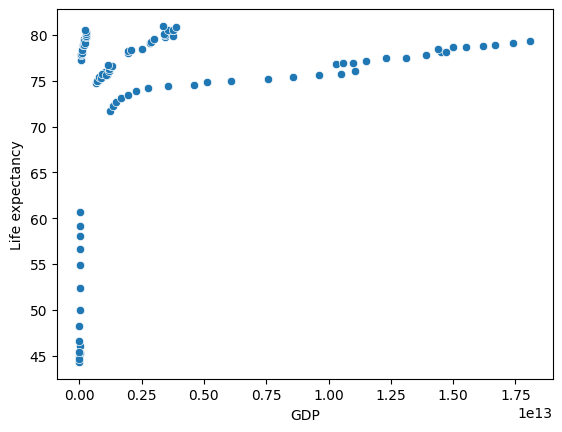

<Figure size 640x480 with 0 Axes>

In [8]:
fig1 = plt.figure()
sns.scatterplot(data=gdp, x = 'GDP', y= 'Life expectancy')
fig1.savefig('./figures/life_expectancy_to_gdp', bbox_inches='tight')
plt.show()
plt.clf()

Interesting! It seem that there is some kind of a correlation. But it's not a simple one. While Life expectancy does increase in broad terms with GDP it seem that there are other factors which complicate the story. Notice the various strata present in the plot. I suspect these strata represent each of the countries. 

## GDP and Life expectancy by country.

To get a different view of what is going on lets plot both the mean GDP and mean life expectancy for each of the countries, ordered by GDP. Remember the data we are looking at ranges from 2000 to 2015.

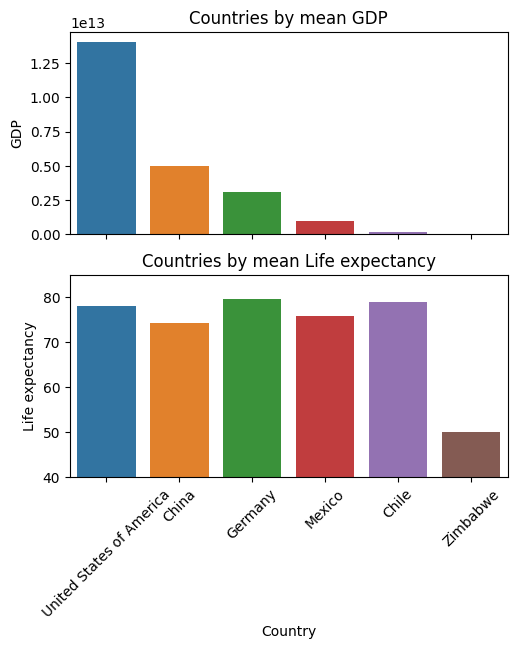

<Figure size 640x480 with 0 Axes>

In [9]:
# Countries ordered by GDP
fig2 = plt.figure(figsize=(5, 5))
avg_gdp = gdp.groupby(['Country']).mean().sort_values(by='GDP', ascending=False)

plt.subplot(2, 1, 1)
g1 = sns.barplot(data=avg_gdp, x=avg_gdp.index, y='GDP')
plt.title("Countries by mean GDP")
g1.set(xticklabels=[])
g1.set(xlabel=None)

# Countries by life expectancy, ordered by GDP
mean_life_expectancy = gdp.groupby(['Country']).mean().sort_values(by='Life expectancy', ascending=False)
plt.subplot(2, 1, 2)
sns.barplot(data=mean_life_expectancy, x=mean_life_expectancy.index, y='Life expectancy', order=avg_gdp.index, errorbar=None)
plt.xticks(rotation=45)
plt.title("Countries by mean Life expectancy")
plt.subplots_adjust(hspace=0.2, wspace=0.3, top=1, right=1)
plt.ylim(40, 85)
fig2.savefig('./figures/mean_life_expectancy_to_gdp_by_country.png', bbox_inches='tight')
plt.show()
plt.clf()

Oddly there doesn't seem to be much of a correlation based on these two graphs. The USA has by far the largest GDP and yet is only the third highest in terms of life expectancy. It has an even low mean life expectancy than Chile, with the second smallest GDP. Likewise China with the second largest GDP comes in at only 5th of the 6 counties in terms of life expectancy.

GDP it's self doesn't seem to correlate with life expectancy at least across countries. This might be because counties with the largest GDP also have the largest population. So one option would be to compare life expectancy with GDP per capita, which is GDP diveded by the population of a country.

## GDP per capita

We can download data for GDP per capita from this site https://www.macrotrends.net/countries/DEU/germany/gdp-per-capita. We can then process the data and do the comparison.

In [10]:
gdp_per_capita_path = Path('.') / 'gdp_per_capita/'
gdp_per_capita_files = sorted(gdp_per_capita_path.glob('*.csv'))

In [11]:
def get_country_name_from_path(path):
    country_ = path.parts[-1].split('-')[:-3]
    return '_'.join(country_)

def clean_data(df, country_name):
    size = df.shape[0]
    years = [int(new_date[0:4]) for new_date in df.date.values]
    df['Year'] = years
    ret = pd.DataFrame()
    ret['Country'] = [country_name] * size
    ret['Year'] = df['Year']
    ret['GDP Per Capita (US $)'] = df[' GDP Per Capita (US $)']
    return ret

In [12]:
country_names = [get_country_name_from_path(path).capitalize() for path in gdp_per_capita_files]
country_names[country_names.index('United_states')] = 'USA'
country_names

['Chile', 'China', 'Germany', 'Mexico', 'USA', 'Zimbabwe']

In [13]:
gdp_per_cap_raw = [pd.read_csv(file, skiprows=16) for file in gdp_per_capita_files]
gdp_per_cap_raw[0].columns

Index(['date', ' GDP Per Capita (US $)', ' Annual Growth Rate (%)', ' '], dtype='object')

In [14]:
gdp_per_cap_list = [clean_data(df, country_name) 
                    for df, country_name 
                    in zip(gdp_per_cap_raw, country_names)]

In [15]:
gdp.set_index(['Country', 'Year'], inplace=True)

In [16]:
gdp_per_cap = pd.concat(gdp_per_cap_list)
gdp_per_cap.set_index(['Country', 'Year'], inplace=True)
gdp_per_cap.loc['Zimbabwe']

,GDP Per Capita (US $)
Year,
1960,276.6434
1961,279.3327
1962,275.9661
1963,277.5325
1964,282.3769
...,...
2018,2269.1770
2019,1421.8686
2020,1372.6967


In [17]:
gdp_per_cap = gdp.join(gdp_per_cap, how='inner')
gdp_per_cap = gdp_per_cap.reset_index()
gdp_per_cap

,Country,Year,Life expectancy,GDP,GDP Per Capita (US $)
0,Chile,2000,77.3,7.786093e+10,5097.1149
1,Chile,2001,77.3,7.097992e+10,4606.8906
2,Chile,2002,77.8,6.973681e+10,4479.1750
3,Chile,2003,77.9,7.564346e+10,4824.2205
4,Chile,2004,78.0,9.921039e+10,6185.5148
...,...,...,...,...,...
75,Zimbabwe,2011,54.9,1.209845e+10,1082.6158
76,Zimbabwe,2012,56.6,1.424249e+10,1290.1940
77,Zimbabwe,2013,58.0,1.545177e+10,1408.3678
78,Zimbabwe,2014,59.2,1.589105e+10,1407.0343


## GDP per capita and life expectancy by country

Here is the same plot as above but this time using GDP per capita agianst life expectancy, instead of just GDP.

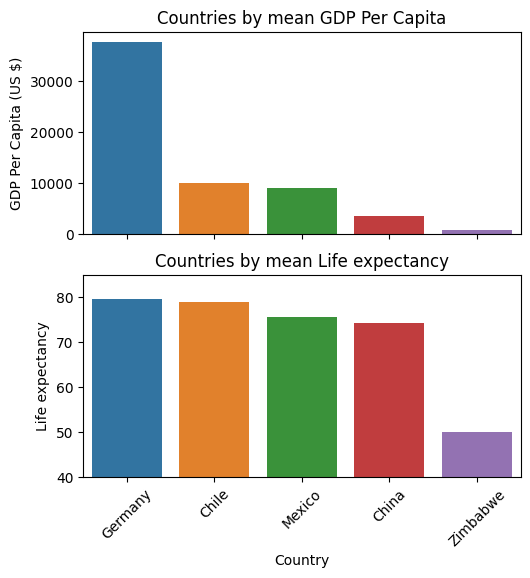

<Figure size 640x480 with 0 Axes>

In [18]:
# Countries ordered by GDP per capita
fig5 = plt.figure(figsize=(5, 5))
avg_gdp = gdp_per_cap.groupby(['Country']).mean().sort_values(by='GDP Per Capita (US $)', ascending=False)

plt.subplot(2, 1, 1)
g1 = sns.barplot(data=avg_gdp, x=avg_gdp.index, y='GDP Per Capita (US $)')
g1.set(xticklabels=[])
g1.set(xlabel=None)
# plt.xticks(rotation=45)
plt.title("Countries by mean GDP Per Capita")

# Countries by life expectancy, ordered by GDP
mean_life_expectancy = gdp.groupby(['Country']).mean().sort_values(by='Life expectancy', ascending=False)
plt.subplot(2, 1, 2)
sns.barplot(data=mean_life_expectancy, x=mean_life_expectancy.index, y='Life expectancy', order=avg_gdp.index, errorbar=None)
plt.xticks(rotation=45)
plt.title("Countries by mean Life expectancy")
plt.subplots_adjust(hspace=0.2, wspace=0.3, top=1, right=1)
plt.ylim(40, 85)
fig5.savefig('./figures/mean_life_expectancy_to_gdp_per_cap_by_country.png', bbox_inches='tight')
plt.show()
plt.clf()

Now we can see that the countries with the hightest GDP per capita also have the highest life expectancy.
The anomaly being the USA which has the highest GDP per capita but is only third highest in terms of life expectancy. The reason for this is unclear and would need further research.

The other standout country is Zimbabwe with a very low life expectancy of just over 50 years. Again the reason for this would need looking into further. Perhaps high child mortality is a factor.

## GDP against life expectancy per county

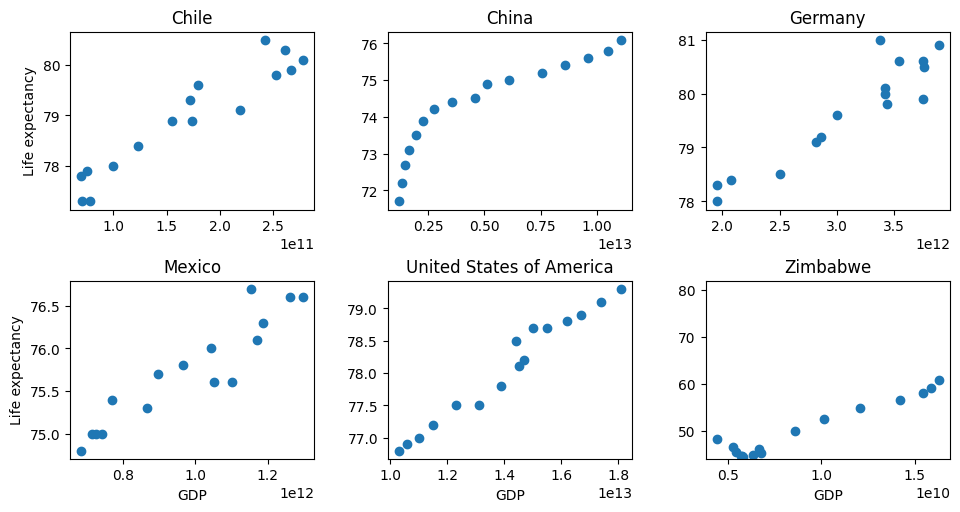

<Figure size 640x480 with 0 Axes>

In [26]:
gdp = gdp.reset_index()
fig3 = plt.figure()
max_age = np.round(gdp['Life expectancy'].max()) + 1
min_age = np.floor(gdp['Life expectancy'].min())
x_col = 'GDP'
y_col = 'Life expectancy'
num_rows = 2
num_cols = 3
num_countries = len(countries)
age = np.sort(gdp[y_col].unique())
axis = []
for i, country in enumerate(countries):
    country_data = gdp[gdp['Country']==country]
    plt.subplot(num_rows, num_cols, i+1)
    plt.scatter(country_data[x_col], country_data[y_col])
    plt.title(country)
    if i > num_rows:
        plt.xlabel(x_col)
    if i % num_cols == 0:
        plt.ylabel(y_col)
plt.subplots_adjust(hspace=0.4, wspace=0.3, top=1, right=1.5)
plt.ylim(min_age, max_age)
fig3.savefig('./figures/life_expectancy_to_gdp_by_country.png', bbox_inches='tight')
plt.show()
plt.clf()

The plots above show the life expectancy against GDP for each of the countries.

All the countries show a clear corralation between GDP and life expectancy within the context of each country. With higher GDP corresponding to higher life expectancy. With the average life span ranging roughly between 70 and 80 years. The exception being Zimbabwe with a much lower average life expectancy of roughly 45 to 62 years.
This descrepancy would warrent further investigation.

Between counties there are some inconsistanies which need futher examination. For example the GDP of the USA is much bigger than that of Germany. Yet the life expectancy in Germany is slightly higher, ranging from 
78 to 81 years compared to about 76 to 80 years for the USA. 

Likewise Mexico has a higher GDP than Chile, but has a lower Life expectancy ranging between about 74 to 77 years compared to that of Chile ranging from roughly 77 to 81 years.

What can we conclude from the plots above? It seems that although there is a corralation between GDP and longevity, GDP is not the only factor at play. In fact we can not be sure a this stage if GDP has a causal effect on life expectancy, despite the clear corralation.